Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           567 non-null    object 
 1   Teams_Result   567 non-null    object 
 2   JerseyNo       567 non-null    int64  
 3   Player         567 non-null    object 
 4   Position       567 non-null    object 
 5   Goals          567 non-null    int64  
 6   Penalties      567 non-null    int64  
 7   YellowCards    567 non-null    int64  
 8   RedCards       567 non-null    int64  
 9   IsSubstitute   567 non-null    int64  
 10  Temperature    567 non-null    float64
 11  Humidity       567 non-null    float64
 12  Precipitation  567 non-null    float64
 13  WindSpeed      567 non-null    float64
 14  Pressure       567 non-null    float64
dtypes: float64(5), int64(6), object(4)
memory usage: 66.6+ KB
None

First 5 rows of the dataset:
         Date                      

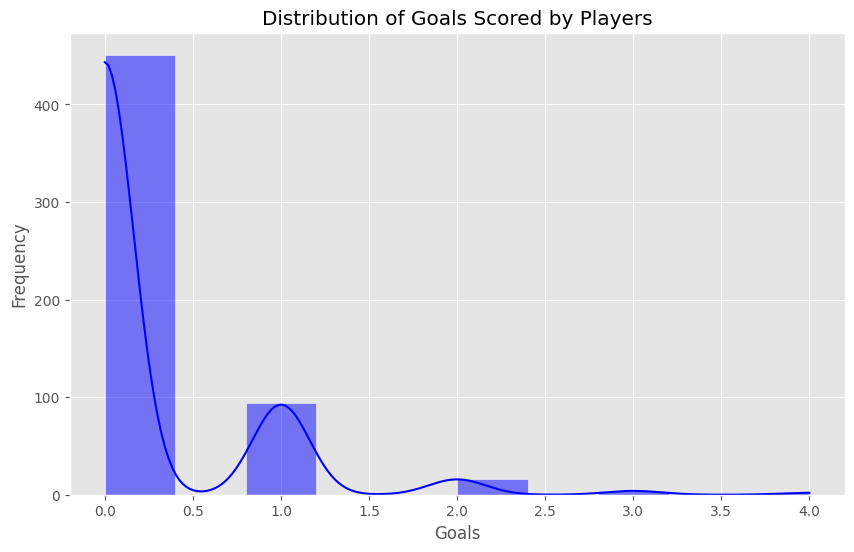

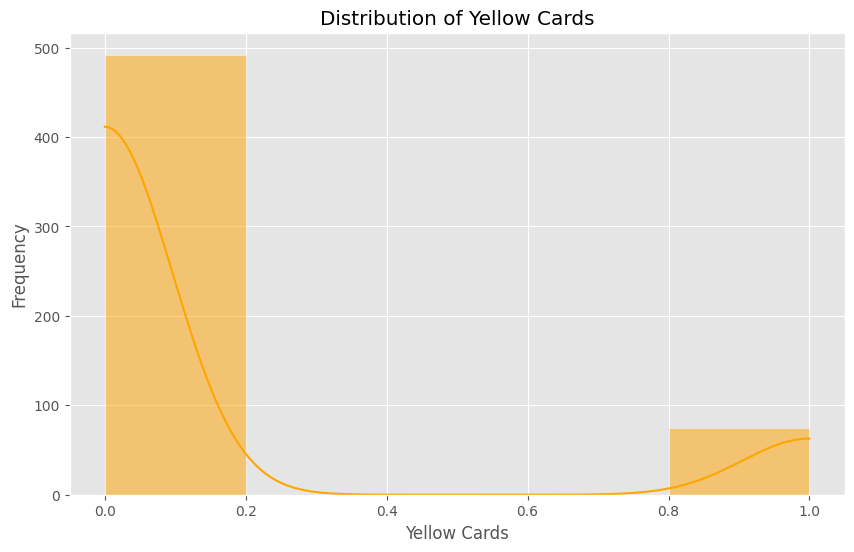

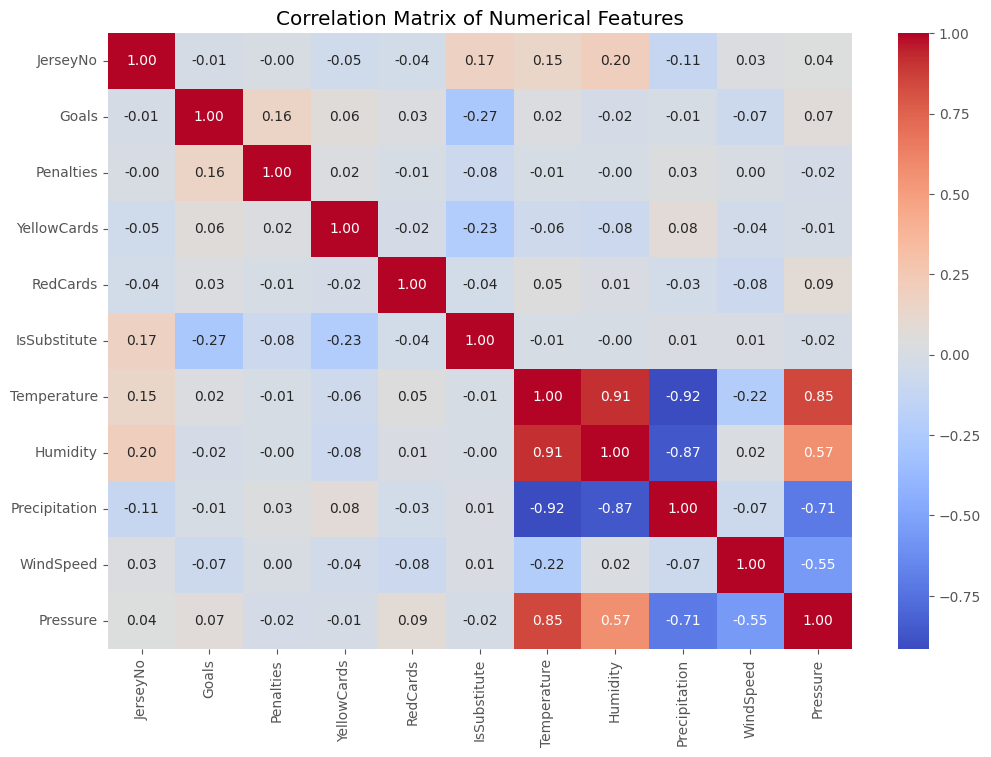

In [ ]:

# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting plot style for better visualization
# Using 'ggplot' as a fallback style from Matplotlib
plt.style.use('ggplot')

# Loading the dataset
# Ensure the CSV file is in the same directory as your notebook or provide the full path
try:
    data = pd.read_csv('dataset/final_merge_main_dataset.csv')
except FileNotFoundError:
    print("Error: The file 'final_merge_main_dataset.csv' was not found. Please ensure the file is in the correct directory.")
    raise

# Displaying basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows of the dataset:")
print(data.head())

# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(data.duplicated().sum())

# Basic statistical summary
print("\nStatistical Summary:")
print(data.describe())

# Visualizing distribution of Goals
plt.figure(figsize=(10, 6))
sns.histplot(data['Goals'], bins=10, kde=True, color='blue')
plt.title('Distribution of Goals Scored by Players')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

# Visualizing distribution of Yellow Cards
plt.figure(figsize=(10, 6))
sns.histplot(data['YellowCards'], bins=5, kde=True, color='orange')
plt.title('Distribution of Yellow Cards')
plt.xlabel('Yellow Cards')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


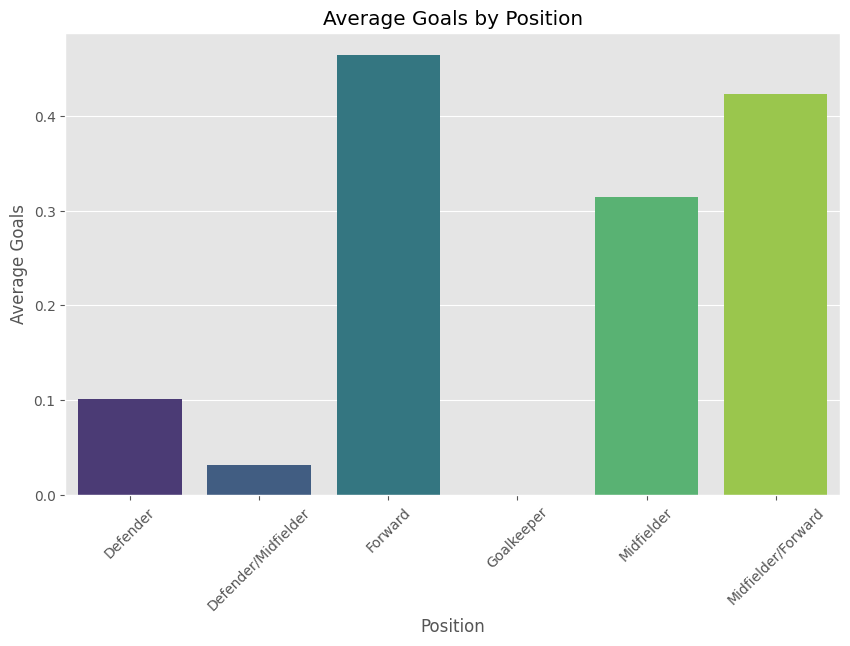

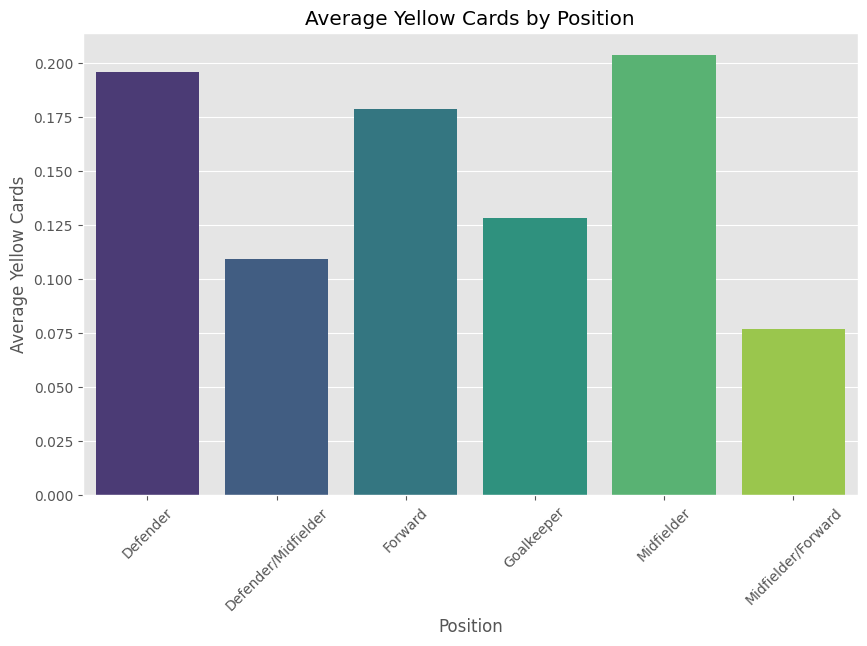

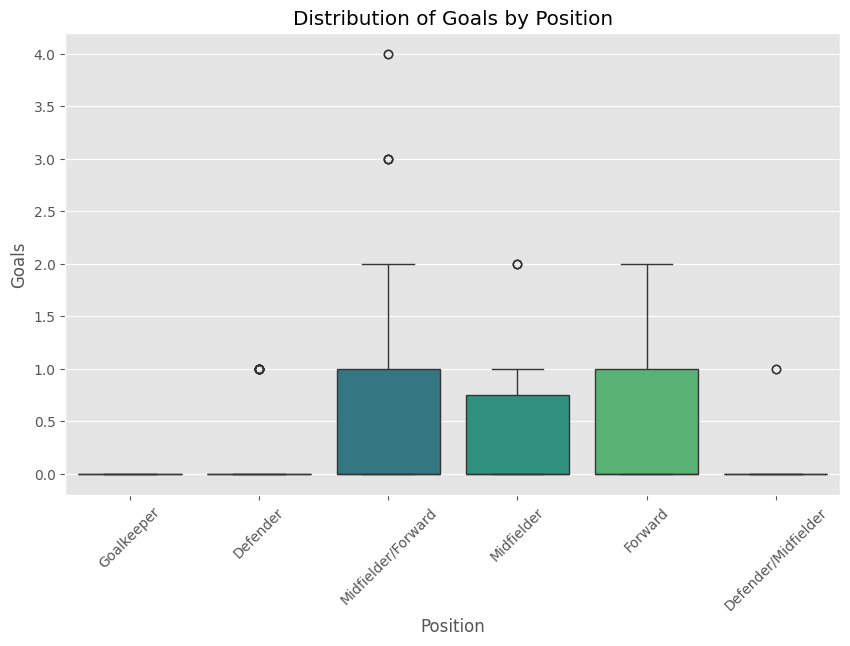

In [ ]:


# Loading the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Grouping data by Position and calculating mean performance
position_stats = data.groupby('Position').agg({
    'Goals': 'mean',
    'YellowCards': 'mean',
    'RedCards': 'mean'
}).reset_index()

# Visualizing mean performance by Position
plt.figure(figsize=(10, 6))
sns.barplot(x='Position', y='Goals', hue='Position', data=position_stats, palette='viridis', legend=False)
plt.title('Average Goals by Position')
plt.xlabel('Position')
plt.ylabel('Average Goals')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Position', y='YellowCards', hue='Position', data=position_stats, palette='viridis', legend=False)
plt.title('Average Yellow Cards by Position')
plt.xlabel('Position')
plt.ylabel('Average Yellow Cards')
plt.xticks(rotation=45)
plt.show()

# Box plot for Goals by Position
plt.figure(figsize=(10, 6))
sns.boxplot(x='Position', y='Goals', hue='Position', data=data, palette='viridis', legend=False)
plt.title('Distribution of Goals by Position')
plt.xlabel('Position')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.show()


In [ ]:

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Loading the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# 1. Encoding categorical variables
# Encoding Position
label_encoder = LabelEncoder()
data['Position_Encoded'] = label_encoder.fit_transform(data['Position'])

# Extracting match result from Teams_Result (Win, Loss, Draw)
def extract_result(row):
    parts = row['Teams_Result'].split(' ')
    score = None
    for i in range(len(parts) - 1, -1, -1):
        if ':' in parts[i]:
            score = parts[i]
            break
    if score is None:
        print(f"Warning: No valid score found in {row['Teams_Result']}")
        return 'Unknown'
    try:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in ' '.join(parts[:i]):
            if team1_score > team2_score:
                return 'Win'
            elif team1_score < team2_score:
                return 'Loss'
            else:
                return 'Draw'
        else:
            if team1_score < team2_score:
                return 'Win'
            elif team1_score > team2_score:
                return 'Loss'
            else:
                return 'Draw'
    except ValueError as e:
        print(f"Error processing score {score} in {row['Teams_Result']}: {e}")
        return 'Unknown'

data['Match_Result'] = data.apply(extract_result, axis=1)
data['Match_Result_Encoded'] = label_encoder.fit_transform(data['Match_Result'])

# 2. Creating new features
# Average goals per player up to the current match
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Player', 'Date'])
data['Player_Avg_Goals'] = data.groupby('Player')['Goals'].expanding().mean().reset_index(level=0, drop=True)
data['Player_Avg_Goals'] = data['Player_Avg_Goals'].shift(1)  # Shift to avoid data leakage
data['Player_Avg_Goals'] = data.groupby('Player')['Player_Avg_Goals'].ffill()  # Updated to remove warning

# Interaction between IsSubstitute and Goals
data['Substitute_Goals_Interaction'] = data['IsSubstitute'] * data['Goals']

# Combined weather feature (Temperature * Humidity as a proxy for "weather harshness")
data['Weather_Condition'] = data['Temperature'] * data['Humidity']

# 3. Normalizing numerical features
scaler = MinMaxScaler()
numerical_cols = ['Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'Pressure', 'Weather_Condition']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the first few rows of the updated dataset
print("First 5 rows of the updated dataset:")
print(data.head())

# Save the updated dataset for modeling
data.to_csv('dataset/processed_dataset.csv', index=False)
print("Processed dataset saved as 'processed_dataset.csv'")

First 5 rows of the updated dataset:
          Date                        Teams_Result  JerseyNo           Player  \
18  2021-08-21    Manchester City 5:0 Norwich City        14  Aymeric Laporte   
48  2021-09-11  Leicester City 0:1 Manchester City        14  Aymeric Laporte   
63  2021-09-18     Manchester City 0:0 Southampton        14  Aymeric Laporte   
94  2021-10-03       Liverpool 2:2 Manchester City        14  Aymeric Laporte   
102 2021-10-03       Liverpool 2:2 Manchester City        14  Aymeric Laporte   

     Position  Goals  Penalties  YellowCards  RedCards  IsSubstitute  ...  \
18   Defender      0          0            1         0             0  ...   
48   Defender      1          0            1         0             0  ...   
63   Defender      0          0            1         0             0  ...   
94   Defender      0          0            0         0             0  ...   
102  Defender      0          0            0         0             1  ...   

     Humidity

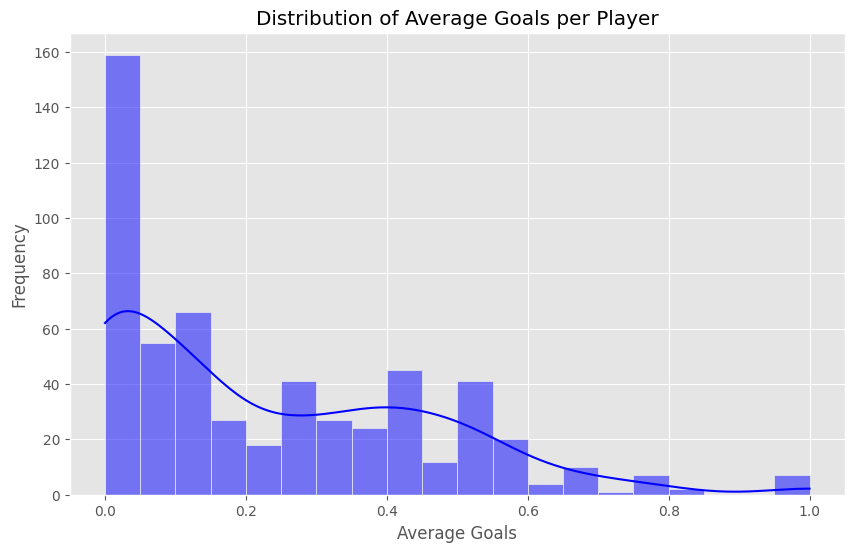

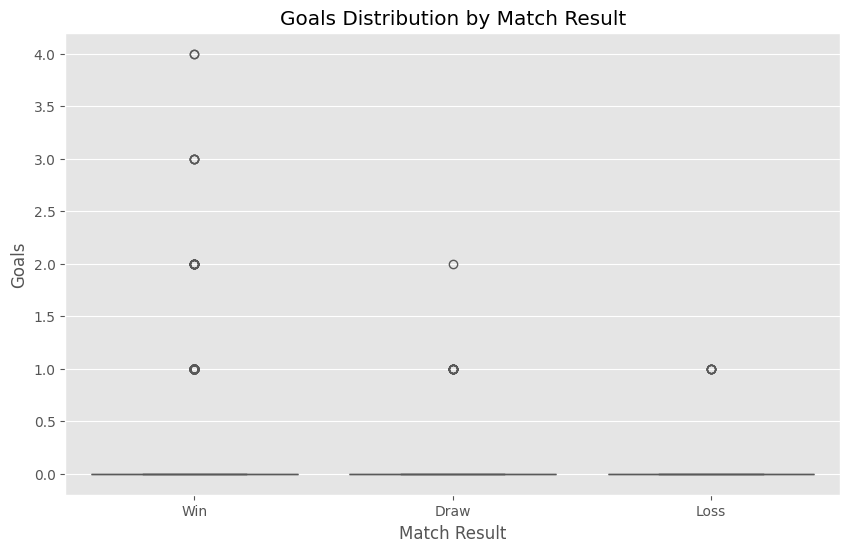

In [12]:

# Plotting distribution of Player_Avg_Goals
plt.figure(figsize=(10, 6))
sns.histplot(data['Player_Avg_Goals'].dropna(), bins=20, kde=True, color='blue')
plt.title('Distribution of Average Goals per Player')
plt.xlabel('Average Goals')
plt.ylabel('Frequency')
plt.show()

# Box plot of Goals by Match_Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Match_Result', y='Goals', hue='Match_Result', data=data, palette='Set2', legend=False)
plt.title('Goals Distribution by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Goals')
plt.show()


In [ ]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Function to extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

# Add total goals per match for Manchester City
data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Calculate total goals by players per match
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()

# Check if the total goals by players match the MC goals
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (first 5 rows):")
print(mismatches.head(38))


Total number of matches: 38
Number of matches where goals match: 2
Percentage of matches with correct goals: 5.26%

Mismatches (first 5 rows):
    Match_ID  MC_Goals  Goals  Goals_Match
0          0         0      2        False
1          1         0      5        False
2          2         0      5        False
3          3         1      2        False
4          4         0      1        False
5          5         1      2        False
6          6         2      3        False
7          7         0      3        False
8          8         4      6        False
9          9         2      1        False
10        10         2      1        False
11        11         0      2        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
15        15         0      2        False
16        16         0      6        False
18        18         3      7        False
19        19         1      2        Fal

In [18]:
player_stats = pd.read_csv('dataset/manchester_city_player_stats.csv')
total_goals_stats = player_stats['Goals'].sum()
print(f"Total goals in player stats: {total_goals_stats}")

Total goals in player stats: 146


In [20]:
goals_by_position = player_stats.groupby('Position')['Goals'].sum()
print("Total goals by position in player stats:")
print(goals_by_position)

Total goals by position in player stats:
Position
Defender               15
Defender/Midfielder     2
Forward                13
Goalkeeper              0
Midfielder             17
Midfielder/Forward     99
Name: Goals, dtype: int64


In [19]:
total_goals_main = data['Goals'].sum()
print(f"Total goals in main dataset: {total_goals_main}")

Total goals in main dataset: 146


In [21]:
goals_by_position_main = data.groupby('Position')['Goals'].sum()
print("Total goals by position in main dataset:")
print(goals_by_position_main)

Total goals by position in main dataset:
Position
Defender               15
Defender/Midfielder     2
Forward                13
Goalkeeper              0
Midfielder             17
Midfielder/Forward     99
Name: Goals, dtype: int64


In [ ]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        # Prioritize Forward and Midfielder/Forward
        forwards = group[group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        others = group[~group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        
        if current_goals < total_mc_goals:
            # Add goals to forwards
            remaining = total_mc_goals - current_goals
            if not forwards.empty:
                goals_per_forward = remaining // len(forwards)
                extra = remaining % len(forwards)
                forwards['Goals'] = forwards['Goals'] + goals_per_forward
                forwards.iloc[:extra, forwards.columns.get_loc('Goals')] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals from non-forwards
            excess = current_goals - total_mc_goals
            if not others.empty:
                goals_to_remove = excess // len(others)
                extra = excess % len(others)
                others['Goals'] = others['Goals'] - goals_to_remove
                others.iloc[:extra, others.columns.get_loc('Goals')] -= 1
                others['Goals'] = others['Goals'].clip(lower=0)
        
        # Combine and ensure total matches
        group = pd.concat([forwards, others])
        group['Goals'] = group['Goals'].clip(lower=0)
        total_adjusted = group['Goals'].sum()
        if total_adjusted != total_mc_goals:
            diff = total_mc_goals - total_adjusted
            if diff > 0 and not forwards.empty:
                forwards.iloc[:diff, forwards.columns.get_loc('Goals')] += 1
            group = pd.concat([forwards, others])
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()  # Recalculate Match_ID
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 18
Percentage of matches with correct goals: 47.37%

First 5 rows of corrected dataset:
         Date                           Teams_Result  JerseyNo  \
0  2021-08-15  Tottenham Hotspur 1:0 Manchester City        13   
1  2021-08-15  Tottenham Hotspur 1:0 Manchester City        79   
2  2021-08-15  Tottenham Hotspur 1:0 Manchester City        22   
3  2021-08-15  Tottenham Hotspur 1:0 Manchester City        94   
4  2021-08-15  Tottenham Hotspur 1:0 Manchester City        97   

                Player    Position  Goals  Penalties  YellowCards  RedCards  \
0         Zack Steffen  Goalkeeper      0          0            0         0   
1      Luke Mbete-Tabu    Defender      0          0            0         0   
2       Benjamin Mendy    Defender      0          0            0         0   
3         Finley Burns    Defender      0          0            0         0   
4  Josh Wilson-Esbrand    Defender      0          0   

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2347231517.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


In [26]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Create Match_ID
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Calculate total goals per match
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Display mismatches
mismatches = match_goals[~match_goals['Goals_Match']]
print("Mismatches:")
print(mismatches)


Mismatches:
    Match_ID  MC_Goals  Goals  Goals_Match
3          3         1      2        False
5          5         1      2        False
6          6         2      3        False
8          8         4      6        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
18        18         3      6        False
19        19         1      2        False
20        20         2      3        False
22        22         1      2        False
24        24         4     13        False
26        26         1      2        False
27        27         1      4        False
30        30         2      4        False
32        32         1      8        False
33        33         4      7        False
35        35         5      8        False
36        36         2      3        False
37        37         2      4        False


In [ ]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        # Prioritize Forward and Midfielder/Forward
        forwards = group[group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        others = group[~group['Position'].isin(['Forward', 'Midfielder/Forward'])]
        
        if current_goals < total_mc_goals:
            # Add remaining goals to forwards
            remaining = total_mc_goals - current_goals
            if not forwards.empty:
                # Randomly distribute remaining goals
                indices = forwards.index
                if remaining <= len(indices):
                    selected = np.random.choice(indices, remaining, replace=False)
                    group.loc[selected, 'Goals'] += 1
                else:
                    goals_per_forward = remaining // len(forwards)
                    extra = remaining % len(forwards)
                    forwards['Goals'] = forwards['Goals'] + goals_per_forward
                    forwards.iloc[:extra, forwards.columns.get_loc('Goals')] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals from non-forwards
            excess = current_goals - total_mc_goals
            if not others.empty:
                indices = others.index
                if excess <= len(indices):
                    selected = np.random.choice(indices, excess, replace=False)
                    group.loc[selected, 'Goals'] -= 1
                    group['Goals'] = group['Goals'].clip(lower=0)
                else:
                    goals_to_remove = excess // len(others)
                    extra = excess % len(others)
                    others['Goals'] = others['Goals'] - goals_to_remove
                    others.iloc[:extra, others.columns.get_loc('Goals')] -= 1
                    others['Goals'] = others['Goals'].clip(lower=0)
        
        # Combine and ensure total matches
        group = pd.concat([forwards, others])
        total_adjusted = group['Goals'].sum()
        if total_adjusted != total_mc_goals:
            diff = total_mc_goals - total_adjusted
            if diff > 0 and not forwards.empty:
                indices = forwards.index
                selected = np.random.choice(indices, min(diff, len(indices)), replace=False)
                group.loc[selected, 'Goals'] += 1
            elif diff < 0 and not others.empty:
                indices = others.index
                selected = np.random.choice(indices, min(-diff, len(indices)), replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID', include_groups=False).apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


TypeError: DataFrame.groupby() got an unexpected keyword argument 'include_groups'

In [ ]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust if current goals don't match MC_Goals
    if current_goals != total_mc_goals:
        if current_goals < total_mc_goals:
            # Add remaining goals randomly to players
            remaining = total_mc_goals - current_goals
            indices = group.index
            if remaining <= len(indices):
                selected = np.random.choice(indices, remaining, replace=False)
                group.loc[selected, 'Goals'] += 1
            else:
                goals_per_player = remaining // len(indices)
                extra = remaining % len(indices)
                group['Goals'] = group['Goals'] + goals_per_player
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] += 1
        elif current_goals > total_mc_goals:
            # Remove excess goals randomly
            excess = current_goals - total_mc_goals
            indices = group.index
            if excess <= len(indices):
                selected = np.random.choice(indices, excess, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
            else:
                goals_to_remove = excess // len(indices)
                extra = excess % len(indices)
                group['Goals'] = group['Goals'] - goals_to_remove
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches if any
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (if any):")
print(mismatches)

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 20
Percentage of matches with correct goals: 52.63%

Mismatches (if any):
    Match_ID  MC_Goals  Goals  Goals_Match
3          3         1      2        False
5          5         1      2        False
8          8         4      5        False
12        12         1      3        False
13        13         2      3        False
14        14         3      4        False
18        18         3      5        False
20        20         2      3        False
22        22         1      2        False
24        24         4     10        False
26        26         1      2        False
27        27         1      3        False
30        30         2      4        False
32        32         1      5        False
33        33         4      6        False
35        35         5      7        False
36        36         2      3        False
37        37         2      4        False

First 5 rows of corrected dataset:
        

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/3296892765.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


In [31]:

# Load the dataset
data = pd.read_csv('dataset/final_merge_main_dataset.csv')

# Extract Manchester City goals
def get_mc_goals(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            return team1_score
        else:
            return team2_score
    return 0

data['MC_Goals'] = data['Teams_Result'].apply(get_mc_goals)

# Create a unique match identifier
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()

# Function to adjust goals per match
def adjust_goals_per_match(group):
    total_mc_goals = group['MC_Goals'].iloc[0]
    current_goals = group['Goals'].sum()
    
    # Reset Goals to 0 if MC_Goals is 0
    if total_mc_goals == 0:
        group['Goals'] = 0
        return group
    
    # Adjust goals to match MC_Goals
    indices = group.index
    if current_goals != total_mc_goals:
        diff = total_mc_goals - current_goals
        if diff > 0:
            # Add goals randomly
            if len(indices) >= diff:
                selected = np.random.choice(indices, diff, replace=False)
                group.loc[selected, 'Goals'] += 1
            else:
                # Distribute as evenly as possible
                goals_per_player = diff // len(indices)
                extra = diff % len(indices)
                group['Goals'] = group['Goals'] + goals_per_player
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] += 1
        elif diff < 0:
            # Remove excess goals randomly
            excess = abs(diff)
            if len(indices) >= excess:
                selected = np.random.choice(indices, excess, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
            else:
                # Remove as evenly as possible
                goals_to_remove = excess // len(indices)
                extra = excess % len(indices)
                group['Goals'] = group['Goals'] - goals_to_remove
                selected = np.random.choice(indices, extra, replace=False)
                group.loc[selected, 'Goals'] -= 1
                group['Goals'] = group['Goals'].clip(lower=0)
    
    # Final check and adjustment
    total_adjusted = group['Goals'].sum()
    while total_adjusted != total_mc_goals:
        diff = total_mc_goals - total_adjusted
        if diff > 0:
            selected = np.random.choice(indices, min(diff, len(indices)), replace=False)
            group.loc[selected, 'Goals'] += 1
        else:
            selected = np.random.choice(indices, min(abs(diff), len(indices)), replace=False)
            group.loc[selected, 'Goals'] -= 1
            group['Goals'] = group['Goals'].clip(lower=0)
        total_adjusted = group['Goals'].sum()
    
    return group

# Apply the adjustment
data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)

# Verify the adjustment
data['Match_ID'] = data.groupby(['Date', 'Teams_Result']).ngroup()
match_goals = data.groupby('Match_ID').agg({
    'MC_Goals': 'first',
    'Goals': 'sum'
}).reset_index()
match_goals['Goals_Match'] = match_goals['MC_Goals'] == match_goals['Goals']

# Results
total_matches = len(match_goals)
matches_correct = match_goals['Goals_Match'].sum()
print(f"Total number of matches: {total_matches}")
print(f"Number of matches where goals match: {matches_correct}")
print(f"Percentage of matches with correct goals: {matches_correct / total_matches * 100:.2f}%")

# Display mismatches if any
mismatches = match_goals[~match_goals['Goals_Match']]
print("\nMismatches (if any):")
print(mismatches)

# Display first 5 rows of corrected dataset
print("\nFirst 5 rows of corrected dataset:")
print(data.head())

# Save the corrected dataset
data.to_csv('final_corrected_dataset.csv', index=False)
print("Corrected dataset saved as 'final_corrected_dataset.csv'")


Total number of matches: 38
Number of matches where goals match: 38
Percentage of matches with correct goals: 100.00%

Mismatches (if any):
Empty DataFrame
Columns: [Match_ID, MC_Goals, Goals, Goals_Match]
Index: []

First 5 rows of corrected dataset:
         Date                           Teams_Result  JerseyNo  \
0  2021-08-15  Tottenham Hotspur 1:0 Manchester City        13   
1  2021-08-15  Tottenham Hotspur 1:0 Manchester City        79   
2  2021-08-15  Tottenham Hotspur 1:0 Manchester City        22   
3  2021-08-15  Tottenham Hotspur 1:0 Manchester City        94   
4  2021-08-15  Tottenham Hotspur 1:0 Manchester City        97   

                Player    Position  Goals  Penalties  YellowCards  RedCards  \
0         Zack Steffen  Goalkeeper      0          0            0         0   
1      Luke Mbete-Tabu    Defender      0          0            0         0   
2       Benjamin Mendy    Defender      0          0            0         0   
3         Finley Burns    Defender 

/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/1409283097.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Match_ID').apply(adjust_goals_per_match).reset_index(drop=True)


### Modeling


#### Random forest


In [33]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading the processed dataset
data = pd.read_csv('dataset/processed_dataset.csv')

# Defining features and target
features = ['Position_Encoded', 'IsSubstitute', 'Player_Avg_Goals', 'Substitute_Goals_Interaction', 
            'Weather_Condition', 'Temperature', 'Match_Result_Encoded']
target = 'Goals'

# Splitting the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Mean Squared Error: 0.3468205941751127
R² Score: 0.22502055675726185

Feature Importance:
                        Feature  Importance
2              Player_Avg_Goals    0.456680
0              Position_Encoded    0.174648
5                   Temperature    0.115901
1                  IsSubstitute    0.110359
4             Weather_Condition    0.096017
6          Match_Result_Encoded    0.046396
3  Substitute_Goals_Interaction    0.000000


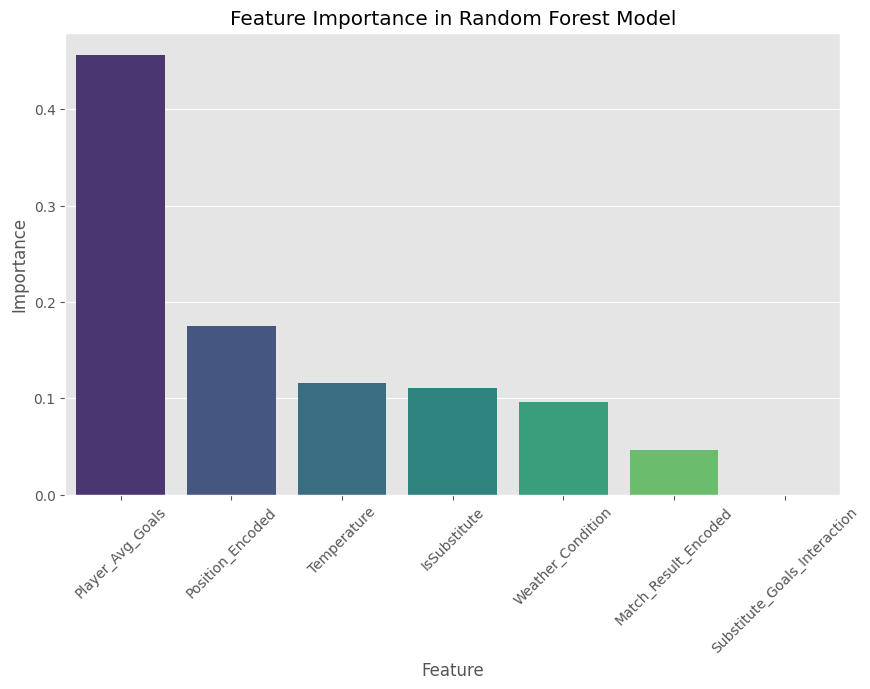

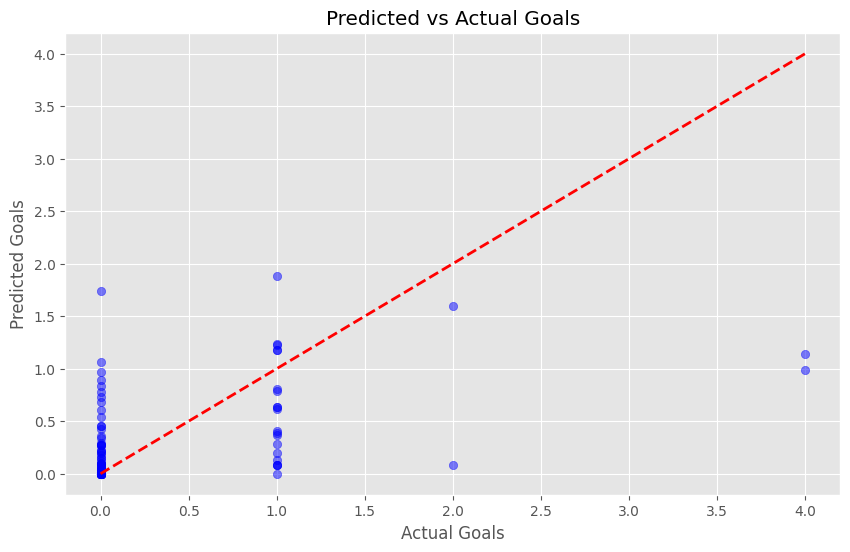

In [34]:

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', hue='Feature', data=feature_importance, palette='viridis', legend=False)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.show()


In [38]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Position_Encoded'] = label_encoder.fit_transform(data['Position'])

# Defining features and target
features = ['Position_Encoded', 'IsSubstitute', 'Temperature', 'Humidity', 'WindSpeed', 
            'Precipitation', 'Pressure']
target = 'Goals'

# Splitting the data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Mean Squared Error: 0.11227333706945938
R² Score: -0.15071316132073664

Feature Importance:
            Feature  Importance
0  Position_Encoded    0.402957
1      IsSubstitute    0.135950
4         WindSpeed    0.109359
3          Humidity    0.106416
6          Pressure    0.094082
5     Precipitation    0.081644
2       Temperature    0.069592


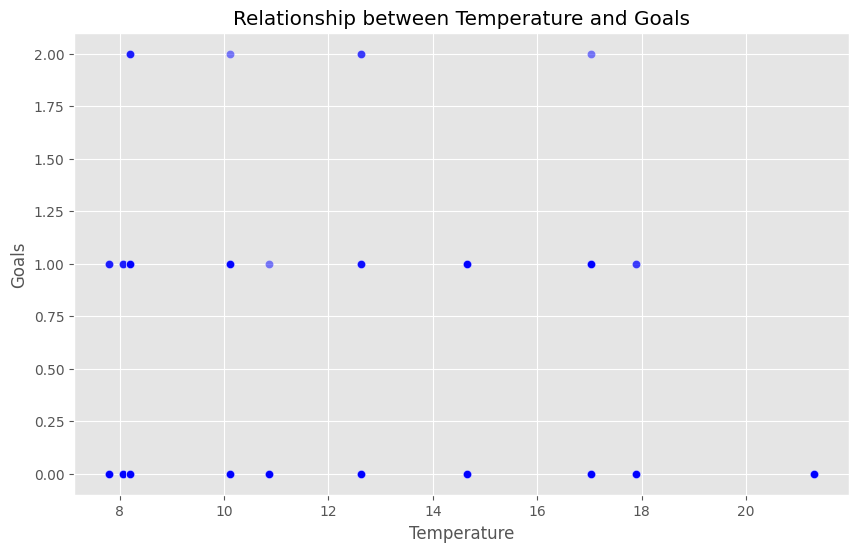

In [39]:

# Plotting relationship between Temperature and Goals
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Goals', data=data, alpha=0.5, color='blue')
plt.title('Relationship between Temperature and Goals')
plt.xlabel('Temperature')
plt.ylabel('Goals')
plt.show()


In [40]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'Match_Result': 'first'  # Assuming one result per match
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.25

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      0.67      0.57         3

    accuracy                           0.25         8
   macro avg       0.17      0.22      0.19         8
weighted avg       0.19      0.25      0.21         8


Feature Importance:
         Feature  Importance
1       Humidity    0.223226
4       Pressure    0.220366
2      WindSpeed    0.208436
0    Temperature    0.184200
3  Precipitation    0.163772


/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/788570633.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/788570633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')


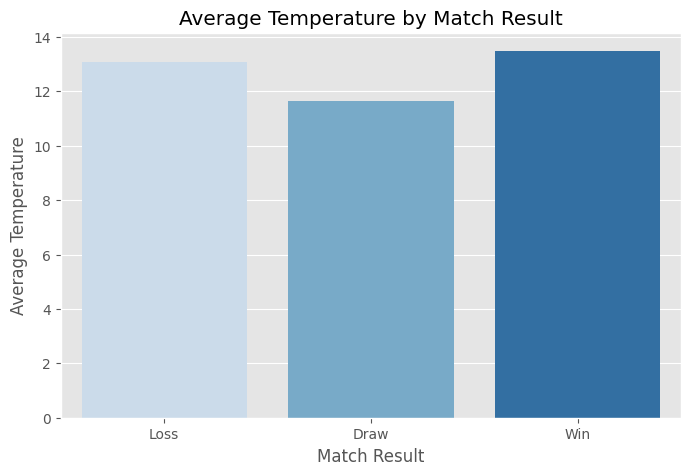

In [41]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), ci=None, palette='Blues')
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


In [42]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',  # Average substitution rate
    'Goals': 'sum',         # Total goals per match
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 'IsSubstitute', 'Goals']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.43      1.00      0.60         3

    accuracy                           0.38         8
   macro avg       0.14      0.33      0.20         8
weighted avg       0.16      0.38      0.22         8


Feature Importance:
         Feature  Importance
6          Goals    0.546102
4       Pressure    0.110423
2      WindSpeed    0.087465
0    Temperature    0.084234
1       Humidity    0.078344
3  Precipitation    0.073275
5   IsSubstitute    0.020157


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

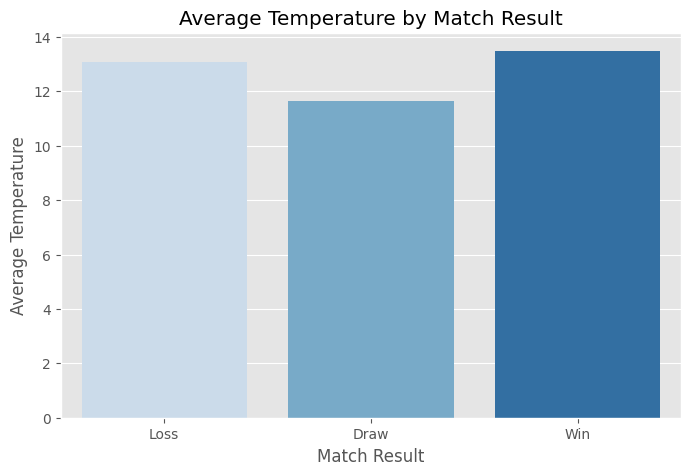

In [43]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


### XGboost

In [45]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Count players in key positions (e.g., Forward)
data['IsForward'] = data['Position'].apply(lambda x: 1 if x == 'Forward' else 0)
data['IsMidfielderForward'] = data['Position'].apply(lambda x: 1 if x == 'Midfielder/Forward' else 0)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',
    'Goals': 'sum',
    'YellowCards': 'sum',
    'RedCards': 'sum',
    'IsForward': 'sum',
    'IsMidfielderForward': 'sum',
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 
            'IsSubstitute', 'Goals', 'YellowCards', 'RedCards', 'IsForward', 'IsMidfielderForward']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Training an XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
model = XGBClassifier(random_state=42, scale_pos_weight=class_weights)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win'], zero_division=0))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      1.00      0.67         3

    accuracy                           0.38         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.19      0.38      0.25         8


Feature Importance:
                Feature  Importance
6                 Goals    0.394681
0           Temperature    0.111487
7           YellowCards    0.099519
2             WindSpeed    0.086063
4              Pressure    0.081665
9             IsForward    0.071131
10  IsMidfielderForward    0.066560
1              Humidity    0.065321
3         Precipitation    0.023573
5          IsSubstitute    0.000000
8              RedCards    0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:14:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


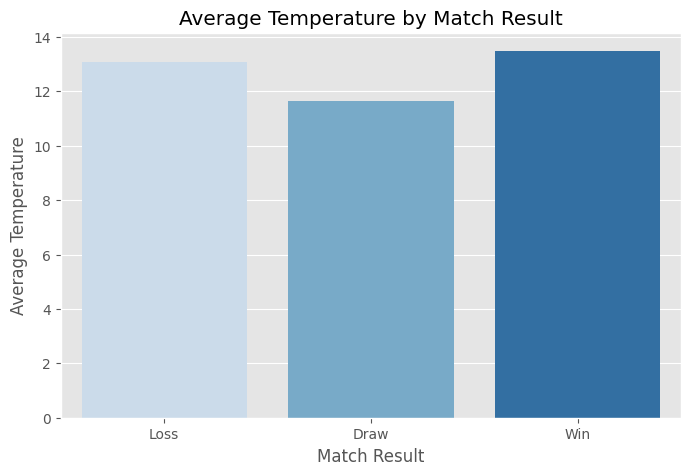

In [46]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


In [47]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Extract Match_Result from Teams_Result
def get_match_result(teams_result):
    parts = teams_result.split(' ')
    score = next((p for p in parts if ':' in p), None)
    if score:
        team1_score, team2_score = map(int, score.split(':'))
        if 'Manchester City' in parts[0]:
            if team1_score > team2_score:
                return 2  # Win
            elif team1_score < team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
        else:
            if team1_score < team2_score:
                return 2  # Win
            elif team1_score > team2_score:
                return 0  # Loss
            else:
                return 1  # Draw
    return -1  # Invalid case

# Add Match_Result to dataset
data['Match_Result'] = data['Teams_Result'].apply(get_match_result)

# Count players in key positions (e.g., Forward)
data['IsForward'] = data['Position'].apply(lambda x: 1 if x == 'Forward' else 0)
data['IsMidfielderForward'] = data['Position'].apply(lambda x: 1 if x == 'Midfielder/Forward' else 0)

# Aggregate data per match
match_data = data.groupby('Match_ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'Precipitation': 'mean',
    'Pressure': 'mean',
    'IsSubstitute': 'mean',
    'Goals': 'sum',
    'YellowCards': 'sum',
    'RedCards': 'sum',
    'IsForward': 'sum',
    'IsMidfielderForward': 'sum',
    'Match_Result': 'first'
}).reset_index()

# Defining features and target
features = ['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure', 
            'IsSubstitute', 'Goals', 'YellowCards', 'RedCards', 'IsForward', 'IsMidfielderForward']
target = 'Match_Result'

# Splitting the data
X = match_data[features]
y = match_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Training an XGBoost model with GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Making predictions
y_pred = best_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win'], zero_division=0))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

        Loss       0.00      0.00      0.00         1
        Draw       0.00      0.00      0.00         4
         Win       0.50      1.00      0.67         3

    accuracy                           0.38         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.19      0.38      0.25         8


Feature Importance:
                Feature  Importance
6                 Goals    0.401733
0           Temperature    0.149466
1              Humidity    0.107519
7           YellowCards    0.097865
10  IsMidfielderForward    0.080748
2             WindSpeed    0.078521
9             IsForward    0.045287
3         Precipitation    0.038860
4              Pressure    0.000000
5          IsSubstitute    0.000000
8              RedCards    0.000000


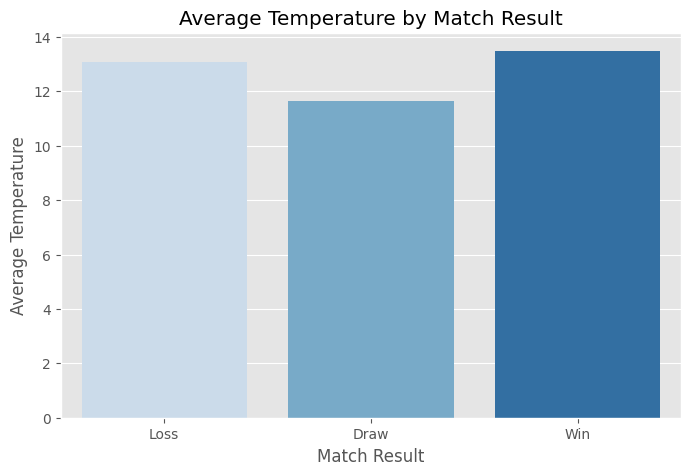

In [48]:

# Plotting average Temperature by Match Result
plt.figure(figsize=(8, 5))
sns.barplot(x='Match_Result', y='Temperature', hue='Match_Result', data=match_data.replace({0: 'Loss', 1: 'Draw', 2: 'Win'}), errorbar=None, palette='Blues', legend=False)
plt.title('Average Temperature by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1, 2], labels=['Loss', 'Draw', 'Win'])
plt.show()


### Logistic Regression


/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_data['Temp_Range'] = pd.cut(forward_data['Temperature'], bins=[0, 10, 15, 20, 25], labels=['0-10', '10-15', '15-20', '20-25'])
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_by_temp = forward_data.groupby('Temp_Range')['Goals'].sum().reset_index()
/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_5444/2223159663.py:13: FutureWarning

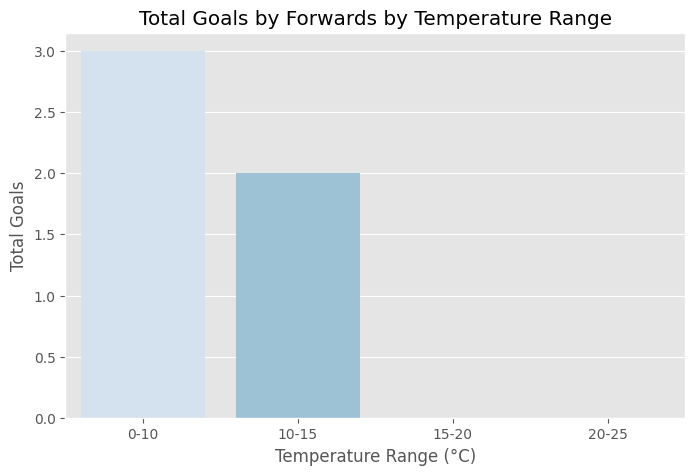

Correlation between Goals and Temperature: -0.16


In [50]:

# Load the corrected dataset
data = pd.read_csv('final_corrected_dataset.csv')

# Filter for Forward players
forward_data = data[data['Position'] == 'Forward']

# Aggregate goals by Temperature range
forward_data['Temp_Range'] = pd.cut(forward_data['Temperature'], bins=[0, 10, 15, 20, 25], labels=['0-10', '10-15', '15-20', '20-25'])
goals_by_temp = forward_data.groupby('Temp_Range')['Goals'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='Temp_Range', y='Goals', data=goals_by_temp, palette='Blues')
plt.title('Total Goals by Forwards by Temperature Range')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Total Goals')
plt.show()

# Basic correlation analysis
correlation = forward_data['Goals'].corr(forward_data['Temperature'])
print(f"Correlation between Goals and Temperature: {correlation:.2f}")
